### Model Catalog: train the model

* dataset: Breast Cancer Dataset
* model: LightGBM

The goal here is not to develop the best model. We will use some reasonable techniques to get a good model and then we will save it to the model catalog

In [43]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import lightgbm as lgb

In [10]:
### load the data from sklearn
data = load_breast_cancer(as_frame=True)

# as Pandas DataFRame
orig_df = data.frame

orig_df.shape

(569, 31)

In [15]:
# target column
orig_df['target'].unique()

array([0, 1])

In [18]:
# static train/validation split
TRAIN_FRAC = 0.8
NUM_TRAIN = int(TRAIN_FRAC*orig_df.shape[0])

# shuffle
orig_df = orig_df.sample(frac = 1.)

train_df = orig_df[0:NUM_TRAIN]
valid_df = orig_df[NUM_TRAIN:]

print('Num training samples:', train_df.shape[0])
print('Num validation samples:', valid_df.shape[0])

Num training samples: 455
Num validation samples: 114


In [19]:
train_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
15,14.540,27.54,96.73,658.8,0.11390,0.15950,0.16390,0.07364,0.2303,0.07077,...,37.13,124.10,943.2,0.1678,0.65770,0.70260,0.17120,0.4218,0.13410,0
52,11.940,18.24,75.71,437.6,0.08261,0.04751,0.01972,0.01349,0.1868,0.06110,...,21.33,83.67,527.2,0.1144,0.08906,0.09203,0.06296,0.2785,0.07408,1
43,13.280,20.28,87.32,545.2,0.10410,0.14360,0.09847,0.06158,0.1974,0.06782,...,28.00,113.10,907.2,0.1530,0.37240,0.36640,0.14920,0.3739,0.10270,0
175,8.671,14.45,54.42,227.2,0.09138,0.04276,0.00000,0.00000,0.1722,0.06724,...,17.04,58.36,259.2,0.1162,0.07057,0.00000,0.00000,0.2592,0.07848,1
336,12.990,14.23,84.08,514.3,0.09462,0.09965,0.03738,0.02098,0.1652,0.07238,...,16.91,87.38,576.0,0.1142,0.19750,0.14500,0.05850,0.2432,0.10090,1


In [23]:
# names
features = [x for x in train_df.columns if x != 'target']

TARGET = 'target'

In [26]:
x_train = train_df[features].values
x_valid = valid_df[features].values

y_train = train_df[TARGET].values
y_valid = valid_df[TARGET].values

In [32]:
# Apply standard scaler: a good enough preprocessing step
sc = StandardScaler()

x_train_scaled = sc.fit_transform(x_train)
x_valid_scaled = sc.transform(x_valid)

### data is ready for training. We will use LightGBM
* all features are continuous

In [39]:
%%time

params = {
   "learning_rate": 0.05
}

model = lgb.LGBMClassifier(objective='binary', seed=4321, n_jobs=-1, n_estimators=100, num_leaves = 30, max_depth=15, early_stopping_rounds=20, 
                          learning_rate = 0.05)

best_model = model.fit(x_train_scaled, y_train, eval_set=[(x_valid_scaled, y_valid)], verbose=1, feature_name=features, eval_metric = 'auc')

/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.976658	valid_0's binary_logloss: 0.602441
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.976658	valid_0's binary_logloss: 0.570547
[3]	valid_0's auc: 0.97894	valid_0's binary_logloss: 0.542051
[4]	valid_0's auc: 0.97894	valid_0's binary_logloss: 0.51706
[5]	valid_0's auc: 0.982801	valid_0's binary_logloss: 0.49427
[6]	valid_0's auc: 0.982976	valid_0's binary_logloss: 0.473601
[7]	valid_0's auc: 0.987364	valid_0's binary_logloss: 0.452641
[8]	valid_0's auc: 0.987364	valid_0's binary_logloss: 0.434237
[9]	valid_0's auc: 0.989119	valid_0's binary_logloss: 0.416401
[10]	valid_0's auc: 0.988066	valid_0's binary_logloss: 0.400428
[11]	valid_0's auc: 0.990523	valid_0's binary_logloss: 0.386491
[12]	valid_0's auc: 0.989821	valid_0's binary_logloss: 0.373434
[13]	valid_0's auc: 0.990523	valid_0's binary_logloss: 0.359405
[14]	valid_0's auc: 0.990172	valid_0's binary_logloss: 0.347737
[15]	valid_0's auc: 0.989119	valid_0's binary_logloss: 0

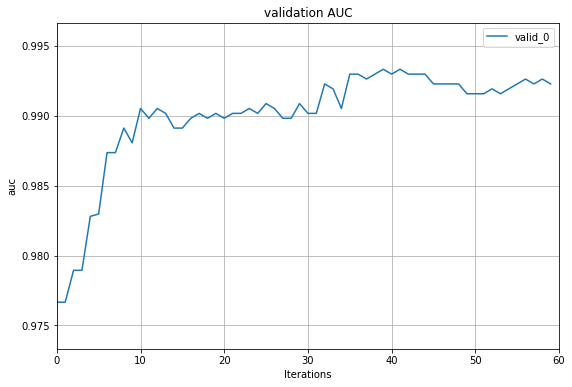

In [40]:
lgb.plot_metric(model, metric='auc', figsize=(9, 6), title='validation AUC');

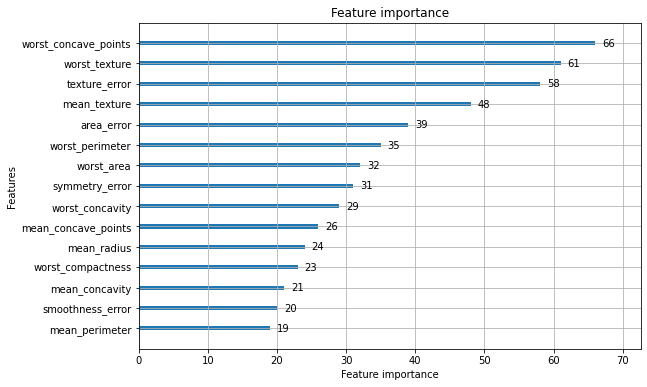

In [42]:
lgb.plot_importance(model, figsize=(9, 6), max_num_features=15);

In [46]:
y_pred = best_model.predict_proba(x_valid_scaled)

y_pred = y_pred[:, 1]

In [48]:
y_pred_labels = best_model.predict(x_valid_scaled)

In [49]:
cm = confusion_matrix(y_valid, y_pred_labels)

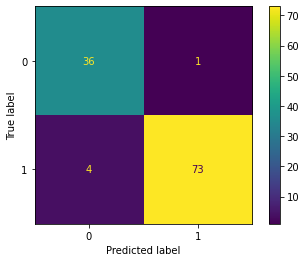

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();